In [1]:
from datahandler import *
from playground import *
from gui import *
from torchutils import *
from models import *
from torch.utils.data import WeightedRandomSampler
import matplotlib.pyplot as plt

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
minute = False
hour = True

In [4]:
data = None
if minute:
    data = pd.read_csv("BTCUSDT_15m.csv")
    data.drop(["Unnamed: 0", "Close Unix"], axis=1, inplace=True)

elif hour:
    data = pd.read_csv("BTCUSDT_1h.csv")
    data.drop(["Unnamed: 0", "Close Unix"], axis=1, inplace=True)

else:
    if not os.path.exists('./BTCUSDT_DB.csv'):
        data = pd.read_csv("BTCUSDT_1m.csv")
        data = get_dollar_bars(data)
        data.to_csv('./BTCUSDT_DB.csv', sep=',')
    else:
        data = pd.read_csv('./BTCUSDT_DB.csv', sep=',')

handler = NewDataHandler(dataset=data)

In [5]:
crossover_horizon = 3

In [6]:
ma1, ma2, ma_mode = 5, 10, 'normal'
ma_modes = {'exponential': 'EMA', 'normal': 'MA'}
ma_name = ma_modes[ma_mode]
k1, k2 = 5, 10

handler.data = ma_crossover_labelling(handler.data, ma1, ma2, crossover_horizon, ma_mode)

handler.data = add_kendall_tau(handler.data, k1)
handler.data = add_kendall_tau(handler.data, k2)

handler.add_indicators([Indicators.RSI, Indicators.MACD,
                       Indicators.ADX, Indicators.OBV, Indicators.NTRADES])

handler.create_var_indicator([Indicators.RSI, Indicators.MACD, Indicators.ADX, Indicators.OBV, Indicators.LOG_RET, Indicators.NTRADES])

# display(handler.data[handler.data.isnull().any(axis=1)]) # Displaying all the rows that contain missing values to see if they are spread across the dataframe

handler.data.replace([np.inf, -np.inf], 0, inplace=True)

# handler.standardize_data()

handler.data.dropna(axis=0, inplace=True)

handler.create_predict_data()

# handler.data.drop('NTrades', axis=1, inplace=True)

predict_data = handler.predict_data
predict_data['Target'] = handler.data['Label']
predict_data[[f'Kendall_{k1}', f'Kendall_{k2}']] = handler.data[[f'Kendall_{k1}', f'Kendall_{k2}']]
predict_data[f'{ma_name}{ma1} Var'], predict_data[f'{ma_name}{ma2} Var'] = handler.data[f'{ma_name}{ma1} Var'], handler.data[f'{ma_name}{ma2} Var']
predict_data[f'Close_{ma_name}{ma1}_PERC_DIFF'], predict_data[f'Close_{ma_name}{ma2}_PERC_DIFF'] = handler.data[f'Close_{ma_name}{ma1}_PERC_DIFF'], handler.data[f'Close_{ma_name}{ma2}_PERC_DIFF']
predict_data[f'{ma_name}{ma1} UP'], predict_data[f'{ma_name}{ma2} UP'] = (handler.data[f'{ma_name}{ma1}'] > handler.data[f'{ma_name}{ma2}']) * 1, (handler.data[f'{ma_name}{ma1}'] < handler.data[f'{ma_name}{ma2}']) * 1
predict_data.reset_index(drop=True, inplace=True)

C:\Users\user\AppData\Local\Temp\ipykernel_12776\2339180592.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data['Target'] = handler.data['Label']
C:\Users\user\AppData\Local\Temp\ipykernel_12776\2339180592.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_data[[f'Kendall_{k1}', f'Kendall_{k2}']] = handler.data[[f'Kendall_{k1}', f'Kendall_{k2}']]
C:\Users\user\AppData\Local\Temp\ipykernel_12776\2339180592.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

In [7]:
handler.data

,Unix,Open,High,Low,Close,Volume,Quote Asset Volume,NTrades,MA5,MA10,MA5 Var,MA10 Var,Close_MA5_PERC_DIFF,Close_MA10_PERC_DIFF,Label,Kendall_5,Kendall_10,RSI,RSI_30-,RSI_BTW,RSI_70+,MACD,MACD_H,ADX14,+DM,-DM,OBV,RSI Var,MACD Var,MACD_H Var,ADX14 Var,-DM Var,+DM Var,OBV Var,LOG_RET,NTrades Var
35,1503068400000,4259.40,4259.40,4200.00,4236.89,39.947717,1.692998e+05,199,4292.280,4298.430,-0.005534,-0.001780,0.013073,0.014525,0,-1.0,-0.155556,39.279221,0,1,0,-23.685670,1.971949,16.866577,12.537813,20.444535,-0.729126,-0.063244,0.196231,-0.689475,0.042830,-0.061125,-0.061125,0.266282,-0.005299,-0.115556
36,1503072000000,4234.54,4283.79,4234.54,4250.34,45.038824,1.918241e+05,197,4274.286,4295.518,-0.004192,-0.000677,0.005634,0.010629,0,-0.8,-0.422222,41.653683,0,1,0,-25.386954,0.216532,16.667163,14.451951,19.386441,3.034805,0.060451,0.071828,-0.890194,-0.011823,-0.051754,0.152669,-5.162249,0.003169,-0.010050
37,1503075600000,4250.34,4250.34,4066.53,4193.35,62.691466,2.633399e+05,164,4246.614,4284.828,-0.006474,-0.002489,0.012702,0.021815,0,-0.8,-0.600000,35.346502,0,1,0,-30.976769,-4.298627,19.128914,11.963386,31.787589,-1.046959,-0.151420,0.220185,-20.852133,0.147701,0.639682,-0.172196,-1.344984,-0.013499,-0.167513
38,1503079200000,4171.17,4297.75,4117.41,4117.41,25.318654,1.052619e+05,174,4211.478,4268.296,-0.008274,-0.003858,0.022846,0.036646,0,-0.8,-0.822222,29.037057,1,0,0,-41.061135,-11.506393,20.133771,14.168620,26.894400,9.004179,-0.178503,0.325546,1.676760,0.052531,-0.153934,0.184332,-9.600318,-0.018276,0.060976
39,1503082800000,4086.28,4136.48,4015.70,4136.28,60.598026,2.469052e+05,218,4186.854,4251.509,-0.005847,-0.003933,0.012227,0.027858,0,-0.6,-0.911111,32.272230,0,1,0,-46.988758,-13.947214,22.111425,12.752743,32.622073,-2.154173,0.111415,0.144361,0.212127,0.098226,0.212969,-0.099931,-1.239241,0.004573,0.252874
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50867,1686524400000,25895.79,25938.80,25819.66,25925.55,1083.956070,2.805894e+07,28875,26004.458,25931.186,-0.000380,0.000858,0.003044,0.000217,-1,-0.4,0.466667,52.711905,0,1,0,40.486013,23.988484,19.144103,22.868803,20.502219,0.001415,0.029829,-0.057274,-0.260648,-0.052131,-0.056266,-0.056266,-1.518269,0.001148,-0.394705
50868,1686528000000,25925.54,26028.50,25856.84,25965.13,1363.722650,3.535156e+07,38669,25991.306,25952.380,-0.000506,0.000817,0.001008,-0.000491,-1,-0.4,0.333333,54.740108,0,1,0,41.254911,19.805906,18.809164,25.228346,18.855978,0.001777,0.038477,0.018992,-0.174358,-0.017496,-0.080296,0.103177,0.256320,0.001526,0.339186
50869,1686531600000,25965.13,26000.00,25891.66,25935.17,1111.029890,2.882563e+07,33125,25953.604,25970.761,-0.001451,0.000708,0.000711,0.001372,1,0.0,0.066667,52.890877,0,1,0,38.997211,14.038565,18.498149,23.922752,17.880161,-0.001445,-0.033782,-0.054726,-0.291193,-0.016535,-0.051751,-0.051751,-1.813258,-0.001155,-0.143371
50870,1686535200000,25935.17,25959.56,25602.11,25773.47,3157.175120,8.132780e+07,71704,25899.024,25961.269,-0.002103,-0.000365,0.004871,0.007287,1,0.0,-0.333333,44.210078,0,1,0,23.884800,-0.859077,18.292081,20.207104,27.684518,-0.004113,-0.164127,-0.387525,-1.061194,-0.011140,0.548337,-0.155319,1.845779,-0.006254,1.164649


In [8]:
predict_data

,Unix,RSI Var,MACD Var,MACD_H Var,ADX14 Var,-DM Var,+DM Var,OBV Var,NTrades Var,RSI_30-,RSI_BTW,RSI_70+,LOG_RET,Target,Kendall_5,Kendall_10,MA5 Var,MA10 Var,Close_MA5_PERC_DIFF,Close_MA10_PERC_DIFF,MA5 UP,MA10 UP
0,1503068400000,-0.063244,0.196231,-0.689475,0.042830,-0.061125,-0.061125,0.266282,-0.115556,0,1,0,-0.005299,0,-1.0,-0.155556,-0.005534,-0.001780,0.013073,0.014525,0,1
1,1503072000000,0.060451,0.071828,-0.890194,-0.011823,-0.051754,0.152669,-5.162249,-0.010050,0,1,0,0.003169,0,-0.8,-0.422222,-0.004192,-0.000677,0.005634,0.010629,0,1
2,1503075600000,-0.151420,0.220185,-20.852133,0.147701,0.639682,-0.172196,-1.344984,-0.167513,0,1,0,-0.013499,0,-0.8,-0.600000,-0.006474,-0.002489,0.012702,0.021815,0,1
3,1503079200000,-0.178503,0.325546,1.676760,0.052531,-0.153934,0.184332,-9.600318,0.060976,1,0,0,-0.018276,0,-0.8,-0.822222,-0.008274,-0.003858,0.022846,0.036646,0,1
4,1503082800000,0.111415,0.144361,0.212127,0.098226,0.212969,-0.099931,-1.239241,0.252874,0,1,0,0.004573,0,-0.6,-0.911111,-0.005847,-0.003933,0.012227,0.027858,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50831,1686524400000,0.029829,-0.057274,-0.260648,-0.052131,-0.056266,-0.056266,-1.518269,-0.394705,0,1,0,0.001148,-1,-0.4,0.466667,-0.000380,0.000858,0.003044,0.000217,1,0
50832,1686528000000,0.038477,0.018992,-0.174358,-0.017496,-0.080296,0.103177,0.256320,0.339186,0,1,0,0.001526,-1,-0.4,0.333333,-0.000506,0.000817,0.001008,-0.000491,1,0
50833,1686531600000,-0.033782,-0.054726,-0.291193,-0.016535,-0.051751,-0.051751,-1.813258,-0.143371,0,1,0,-0.001155,1,0.0,0.066667,-0.001451,0.000708,0.000711,0.001372,0,1
50834,1686535200000,-0.164127,-0.387525,-1.061194,-0.011140,0.548337,-0.155319,1.845779,1.164649,0,1,0,-0.006254,1,0.0,-0.333333,-0.002103,-0.000365,0.004871,0.007287,0,1


In [9]:
handler.data['LOG_RET'].abs().describe()

count    50836.000000
mean         0.005126
std          0.007217
min          0.000000
25%          0.001246
50%          0.002893
75%          0.006134
max          0.201033
Name: LOG_RET, dtype: float64

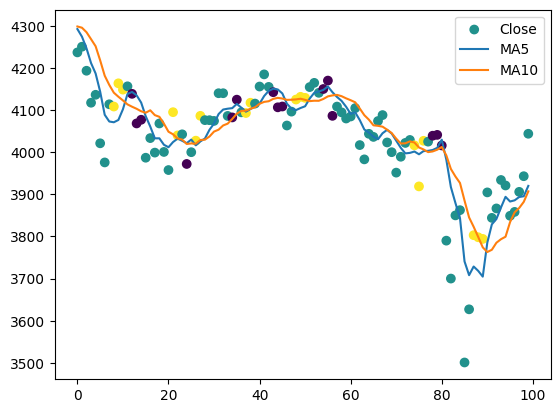

In [10]:
plt.scatter(range(100), handler.data['Close'][0:100], c=handler.data['Label'][0:100], label="Close")
plt.plot(range(100), handler.data[f'{ma_name}{ma1}'][0:100], label=f"{ma_name}{ma1}")
plt.plot(range(100), handler.data[f'{ma_name}{ma2}'][0:100], label=f"{ma_name}{ma2}")
plt.legend()
plt.show()

In [11]:
handler.data

,Unix,Open,High,Low,Close,Volume,Quote Asset Volume,NTrades,MA5,MA10,MA5 Var,MA10 Var,Close_MA5_PERC_DIFF,Close_MA10_PERC_DIFF,Label,Kendall_5,Kendall_10,RSI,RSI_30-,RSI_BTW,RSI_70+,MACD,MACD_H,ADX14,+DM,-DM,OBV,RSI Var,MACD Var,MACD_H Var,ADX14 Var,-DM Var,+DM Var,OBV Var,LOG_RET,NTrades Var
35,1503068400000,4259.40,4259.40,4200.00,4236.89,39.947717,1.692998e+05,199,4292.280,4298.430,-0.005534,-0.001780,0.013073,0.014525,0,-1.0,-0.155556,39.279221,0,1,0,-23.685670,1.971949,16.866577,12.537813,20.444535,-0.729126,-0.063244,0.196231,-0.689475,0.042830,-0.061125,-0.061125,0.266282,-0.005299,-0.115556
36,1503072000000,4234.54,4283.79,4234.54,4250.34,45.038824,1.918241e+05,197,4274.286,4295.518,-0.004192,-0.000677,0.005634,0.010629,0,-0.8,-0.422222,41.653683,0,1,0,-25.386954,0.216532,16.667163,14.451951,19.386441,3.034805,0.060451,0.071828,-0.890194,-0.011823,-0.051754,0.152669,-5.162249,0.003169,-0.010050
37,1503075600000,4250.34,4250.34,4066.53,4193.35,62.691466,2.633399e+05,164,4246.614,4284.828,-0.006474,-0.002489,0.012702,0.021815,0,-0.8,-0.600000,35.346502,0,1,0,-30.976769,-4.298627,19.128914,11.963386,31.787589,-1.046959,-0.151420,0.220185,-20.852133,0.147701,0.639682,-0.172196,-1.344984,-0.013499,-0.167513
38,1503079200000,4171.17,4297.75,4117.41,4117.41,25.318654,1.052619e+05,174,4211.478,4268.296,-0.008274,-0.003858,0.022846,0.036646,0,-0.8,-0.822222,29.037057,1,0,0,-41.061135,-11.506393,20.133771,14.168620,26.894400,9.004179,-0.178503,0.325546,1.676760,0.052531,-0.153934,0.184332,-9.600318,-0.018276,0.060976
39,1503082800000,4086.28,4136.48,4015.70,4136.28,60.598026,2.469052e+05,218,4186.854,4251.509,-0.005847,-0.003933,0.012227,0.027858,0,-0.6,-0.911111,32.272230,0,1,0,-46.988758,-13.947214,22.111425,12.752743,32.622073,-2.154173,0.111415,0.144361,0.212127,0.098226,0.212969,-0.099931,-1.239241,0.004573,0.252874
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50867,1686524400000,25895.79,25938.80,25819.66,25925.55,1083.956070,2.805894e+07,28875,26004.458,25931.186,-0.000380,0.000858,0.003044,0.000217,-1,-0.4,0.466667,52.711905,0,1,0,40.486013,23.988484,19.144103,22.868803,20.502219,0.001415,0.029829,-0.057274,-0.260648,-0.052131,-0.056266,-0.056266,-1.518269,0.001148,-0.394705
50868,1686528000000,25925.54,26028.50,25856.84,25965.13,1363.722650,3.535156e+07,38669,25991.306,25952.380,-0.000506,0.000817,0.001008,-0.000491,-1,-0.4,0.333333,54.740108,0,1,0,41.254911,19.805906,18.809164,25.228346,18.855978,0.001777,0.038477,0.018992,-0.174358,-0.017496,-0.080296,0.103177,0.256320,0.001526,0.339186
50869,1686531600000,25965.13,26000.00,25891.66,25935.17,1111.029890,2.882563e+07,33125,25953.604,25970.761,-0.001451,0.000708,0.000711,0.001372,1,0.0,0.066667,52.890877,0,1,0,38.997211,14.038565,18.498149,23.922752,17.880161,-0.001445,-0.033782,-0.054726,-0.291193,-0.016535,-0.051751,-0.051751,-1.813258,-0.001155,-0.143371
50870,1686535200000,25935.17,25959.56,25602.11,25773.47,3157.175120,8.132780e+07,71704,25899.024,25961.269,-0.002103,-0.000365,0.004871,0.007287,1,0.0,-0.333333,44.210078,0,1,0,23.884800,-0.859077,18.292081,20.207104,27.684518,-0.004113,-0.164127,-0.387525,-1.061194,-0.011140,0.548337,-0.155319,1.845779,-0.006254,1.164649


In [12]:
predict_data

,Unix,RSI Var,MACD Var,MACD_H Var,ADX14 Var,-DM Var,+DM Var,OBV Var,NTrades Var,RSI_30-,RSI_BTW,RSI_70+,LOG_RET,Target,Kendall_5,Kendall_10,MA5 Var,MA10 Var,Close_MA5_PERC_DIFF,Close_MA10_PERC_DIFF,MA5 UP,MA10 UP
0,1503068400000,-0.063244,0.196231,-0.689475,0.042830,-0.061125,-0.061125,0.266282,-0.115556,0,1,0,-0.005299,0,-1.0,-0.155556,-0.005534,-0.001780,0.013073,0.014525,0,1
1,1503072000000,0.060451,0.071828,-0.890194,-0.011823,-0.051754,0.152669,-5.162249,-0.010050,0,1,0,0.003169,0,-0.8,-0.422222,-0.004192,-0.000677,0.005634,0.010629,0,1
2,1503075600000,-0.151420,0.220185,-20.852133,0.147701,0.639682,-0.172196,-1.344984,-0.167513,0,1,0,-0.013499,0,-0.8,-0.600000,-0.006474,-0.002489,0.012702,0.021815,0,1
3,1503079200000,-0.178503,0.325546,1.676760,0.052531,-0.153934,0.184332,-9.600318,0.060976,1,0,0,-0.018276,0,-0.8,-0.822222,-0.008274,-0.003858,0.022846,0.036646,0,1
4,1503082800000,0.111415,0.144361,0.212127,0.098226,0.212969,-0.099931,-1.239241,0.252874,0,1,0,0.004573,0,-0.6,-0.911111,-0.005847,-0.003933,0.012227,0.027858,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50831,1686524400000,0.029829,-0.057274,-0.260648,-0.052131,-0.056266,-0.056266,-1.518269,-0.394705,0,1,0,0.001148,-1,-0.4,0.466667,-0.000380,0.000858,0.003044,0.000217,1,0
50832,1686528000000,0.038477,0.018992,-0.174358,-0.017496,-0.080296,0.103177,0.256320,0.339186,0,1,0,0.001526,-1,-0.4,0.333333,-0.000506,0.000817,0.001008,-0.000491,1,0
50833,1686531600000,-0.033782,-0.054726,-0.291193,-0.016535,-0.051751,-0.051751,-1.813258,-0.143371,0,1,0,-0.001155,1,0.0,0.066667,-0.001451,0.000708,0.000711,0.001372,0,1
50834,1686535200000,-0.164127,-0.387525,-1.061194,-0.011140,0.548337,-0.155319,1.845779,1.164649,0,1,0,-0.006254,1,0.0,-0.333333,-0.002103,-0.000365,0.004871,0.007287,0,1


In [13]:
seq_length = 15
dataset = TSDataset(predict_data, seq_length)

In [14]:
train_indices = range(0, round(0.7 * len(dataset)), int(seq_length))
val_indices = range(round(0.7 * len(dataset)), round(0.9 * len(dataset)), int(seq_length))
test_indices = range(round(0.9 * len(dataset)), len(dataset) - seq_length)

train_set = torch.utils.data.Subset(dataset, train_indices)
val_set = torch.utils.data.Subset(dataset, val_indices) # Validation set will be training set for Meta Labelling
test_set = torch.utils.data.Subset(dataset, test_indices)

In [15]:
label_distribution = (predict_data.loc[train_set.indices, 'Target'].value_counts() / predict_data.loc[train_set.indices, 'Target'].shape[0]).sort_index().to_list()
display(predict_data.loc[train_set.indices, 'Target'].value_counts())
label_distribution

 0    1628
 1     380
-1     364
Name: Target, dtype: int64

[0.15345699831365936, 0.6863406408094435, 0.16020236087689713]

In [16]:
class_weights = [1 / p for p in label_distribution]
print(class_weights)
weights = [class_weights[torch.argmax(label)] for _, label in train_set]
train_sampler = WeightedRandomSampler(weights=weights, num_samples=len(train_set), replacement=True)
# train_sampler = None

[6.516483516483516, 1.4570024570024571, 6.242105263157895]


In [17]:
input_size = dataset.size
hidden_size = 300
batch_size = 16
dynamic_batch = False
num_layers = 3
output_size = predict_data['Target'].unique().size
lstm_model = LSTMModel(input_size, hidden_size,
                       num_layers, output_size).to(device)

In [18]:
weights = torch.Tensor(label_distribution).to(device)
train_lstm(lstm_model, train_set, val_set, 30, 0.0001,
           batch_size, num_layers, hidden_size, device, train_sampler, class_weights=None, model_name=f'crossover_{seq_length}_to_{crossover_horizon}', save=True, dynamic_batch=False)

Epoch: 1/30 -- [596/2372 (100.0%)]	Loss: 1.058609518428777	Accuracy: 0.452	Time taken: 22.234375	Validation Loss: 1.1295185089111328 || Validation Accuracy: 0.314
Epoch: 2/30 -- [596/2372 (100.0%)]	Loss: 0.9162303161301069	Accuracy: 0.629	Time taken: 24.203125	Validation Loss: 1.1786112785339355 || Validation Accuracy: 0.307
Epoch: 3/30 -- [596/2372 (100.0%)]	Loss: 0.9073395845073982	Accuracy: 0.634	Time taken: 22.640625	Validation Loss: 1.159373164176941 || Validation Accuracy: 0.339
Epoch: 4/30 -- [596/2372 (100.0%)]	Loss: 0.8982311143171067	Accuracy: 0.651	Time taken: 23.25	Validation Loss: 1.153673768043518 || Validation Accuracy: 0.364
Epoch: 5/30 -- [596/2372 (100.0%)]	Loss: 0.8871391543605983	Accuracy: 0.659	Time taken: 22.21875	Validation Loss: 1.1716480255126953 || Validation Accuracy: 0.339
Epoch: 6/30 -- [596/2372 (100.0%)]	Loss: 0.8982274292299411	Accuracy: 0.646	Time taken: 29.484375	Validation Loss: 1.1226704120635986 || Validation Accuracy: 0.389
Epoch: 7/30 -- [596/2372

([1.058609518428777,
  0.9162303161301069,
  0.9073395845073982,
  0.8982311143171067,
  0.8871391543605983,
  0.8982274292299411,
  0.8725927328103341,
  0.8639359366173712,
  0.8378628484354723,
  0.7936966455222776,
  0.7224632197578481,
  0.7314771153782839,
  0.7147869355726562,
  0.7117831634995121,
  0.7124127673622745,
  0.7195071786042028,
  0.7027324030063297,
  0.7086390764921303,
  0.6906253203449634,
  0.701471873177778,
  0.7066623768550437,
  0.6914960353966527,
  0.6950202064226138,
  0.6887182389329743,
  0.69838209400241,
  0.6881497382317614,
  0.701692197546863,
  0.6745840639075977,
  0.6894851838982345,
  0.6841245537636264],
 [0.45193929173693087,
  0.6290050590219224,
  0.6344856661045531,
  0.6505059021922428,
  0.6589376053962901,
  0.6462900505902193,
  0.6736930860033726,
  0.6804384485666105,
  0.7107925801011804,
  0.7559021922428331,
  0.8305227655986509,
  0.8157672849915683,
  0.8360033726812817,
  0.8326306913996627,
  0.8381112984822934,
  0.830944350

In [19]:
eval_lstm(lstm_model, test_set, 256, num_layers, hidden_size, device)

Accuracy : 0.7432405762778764 || Loss : 0.8008710741996765
Confusion matrix : 
[[7.110e+02 1.090e+02 1.000e+00]
 [5.130e+02 2.322e+03 5.900e+02]
 [0.000e+00 8.800e+01 7.330e+02]]


(tensor([[1.6644e-17, 4.1683e-05, 9.9996e-01],
         [1.3766e-17, 3.5786e-05, 9.9996e-01],
         [1.2402e-04, 9.9987e-01, 7.2420e-06],
         ...,
         [2.1273e-11, 1.0062e-01, 8.9938e-01],
         [4.0457e-14, 8.6380e-04, 9.9914e-01],
         [4.9720e-15, 1.9102e-04, 9.9981e-01]], grad_fn=<CatBackward0>),
 tensor([[0., 0., 1.],
         [0., 0., 1.],
         [0., 1., 0.],
         ...,
         [0., 1., 0.],
         [0., 1., 0.],
         [0., 0., 1.]]))